In [1]:
# imports
from astropy.io import fits
from scipy import interpolate as sin
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotting as myP
import numpy as np
import csv 
import match
import SED
from astropy.cosmology import FlatLambdaCDM

In [2]:
# path variables 
path_cat = 'D:\IfA REU\Catalogs'
path_fig = 'D:\IfA REU\IfA-REU-Project\Figures'
path_csv = 'D:\IfA REU\IfA-REU-Project\Lists'

# Read Data

In [3]:
# read AGN IDs
agnIDs = myP.ReadFile(path_csv+'\ID_RedYelBlu_AGNselection.csv')

# convert agnIDs into list of integer numpy arrays 
agnIDs_npArray = []
for row in agnIDs : 
    agnIDs_npArray.append(np.array(row, dtype=int))

Cropped:  ['Row 1 = red IR selected AGN. Row 2 = yellow both IR-Xray AGN. Row 3 = blue X-ray selected AGN. Row 4 = blue X-ray selected AGN with IRAC detections. Row 5 = blue X-ray selected AGN without IRAC detections. Row 6 = red IR selected AGN with 24um detection. Row 7 = yellow both IR-Xray AGN with 24um detection. Row 8 = blue X-ray selected AGN with 24um and IRAC detections. Values are ID_COSMOS2015.']


In [4]:
# constants for AGN type index

RED = 0     # red       IR selected AGN
YEL = 1     # yellow    both IR-Xray AGN
BLU = 2     # blue      X-ray selected AGN

BYI = 3     # blue      X-ray selected AGN  with IRAC detections
BNI = 4     # blue      X-ray selected AGN  without IRAC detections

R24 = 5     # red       IR selected AGN     with 24um detection
Y24 = 6     # yellow    both IR-Xray AGN    with 24um detection
B24 = 7     # blue      X-ray selected AGN  with 24um and IRAC detections

In [5]:
def PrintNumber(myList) : 
    # make list of AGN names for printting info 
    agnTypeNames = ['Red:\t', 'Yel:\t', 'Blu:\t', 'Byi:\t', 'Bni:\t', 'r24:\t', 'y24:\t', 'r24:\t']
    # print name and number of items in list 
    for name, row in zip(agnTypeNames, myList) : 
        print(name, row.shape)

In [6]:
# print number of sources in agnIDs_npArray
PrintNumber(agnIDs_npArray)

Red:	 (547,)
Yel:	 (609,)
Blu:	 (1567,)
Byi:	 (1416,)
Bni:	 (151,)
r24:	 (399,)
y24:	 (501,)
r24:	 (1016,)


In [7]:
# read redshifts
zAll = np.array(myP.ReadFile(path_cat+'\COSMOS_z_matches.csv'))
zID, zZ = zAll.T
# get correct data type
zID = np.array(zID, dtype=int)
zZ  = np.array(zZ,  dtype=float)
# apply mask to remove bad redshifts
mask_z = (zZ >= 0) & (zZ < 99)
zID = zID[mask_z]
zZ  = zZ[mask_z]
# print info
print('Number of sources w/ z:', len(zID))

Cropped:  ['ID', 'z']
Number of sources w/ z: 485793


In [8]:
agn_z = []
agn_ID_wZ = []

for row in agnIDs_npArray : 
    # match redshift against AGN IDs
    key_z_agn, key_agn_z = match.match(zID, row)
    # get redshift array for AGN
    agn_z.append(zZ[key_z_agn])
    # get AGN ID arrays w/ redshifts
    agn_ID_wZ.append(row[key_agn_z])

# PrintNumber(agn_z)

In [9]:
# open COSMOS 2020 catalog file and get data 
inf20 = fits.open(path_cat+'\COSMOS2020_CLASSIC_R1_v2.0_master.fits')
data20 = inf20[1].data
inf20.close()

In [10]:
Fnu_uJy = SED.GetPhotometry(data20)
IDs_all = SED.GetID(data20)
lam_A   = SED.GetObservedWavelengths_A()

Array shape:	 (1720700, 20)
Array shape:	 (1720700,)
Array shape:	 (20,)


In [11]:
agn_Fnu_uJy = []
agn_ID_wZ_wPhot = []

for row in agn_ID_wZ : 
    # match photometry IDs against AGN IDs 
    key_IDall_agn, key_agn_IDall = match.match(IDs_all, row)
    # get photometry for AGN
    agn_Fnu_uJy.append(Fnu_uJy[key_IDall_agn])
    # get AGN arrays with photometry 
    agn_ID_wZ_wPhot.append(row[key_agn_IDall])

# PrintNumber(agn_Fnu_uJy)

In [12]:
agn_lamR_A = []

# convert each AGN type to rest wavelength
for row in agn_z : 
    agn_lamR_A.append(SED.ConvertToRestWavelength(row))

Array shape:	 (547, 20)
Array shape:	 (609, 20)
Array shape:	 (1567, 20)
Array shape:	 (1416, 20)
Array shape:	 (151, 20)
Array shape:	 (399, 20)
Array shape:	 (501, 20)
Array shape:	 (1016, 20)


In [13]:
agn_lamFlam_ergscm2 = []

# convert each AGN type to energy density
for lamR,Fnu in zip(agn_lamR_A, agn_Fnu_uJy) : 
    agn_lamFlam_ergscm2.append(SED.ConvertToEnergyDensity(lamR,Fnu))

Array shape:	 (547, 20)
Array shape:	 (609, 20)
Array shape:	 (1567, 20)
Array shape:	 (1416, 20)
Array shape:	 (151, 20)
Array shape:	 (399, 20)
Array shape:	 (501, 20)
Array shape:	 (1016, 20)


In [14]:
# important arrays
    # agn_lamFlam_ergscm2 TEXT
    # agn_Fnu_uJy   flux(frequency) in microJanskys 
    # agn_lamR_A    rest wavelength in angstroms
    # agn_z         redshifts of sources

In [15]:
# PrintNumber(agn_lamR_A)
# print('\n')
# PrintNumber(agn_Fnu_uJy)
# print('\n')
# PrintNumber(agn_z)
# print('\n')

# Luminosity

In [16]:
# TODO                              QUESTIONS
# interpolate Flux                  * do I use Fnu or Flam?
# get value at 1um                  * F-L code unreachable??
# convert F(1um) to Luminosity      * why are there nan in L?
# plot histogram                    * should I be doing log interpolation?

In [17]:
def Flux_to_Lum(F,z):
    # 'Function to convert flux to luminosity’’'
    cosmo = FlatLambdaCDM(H0=70, Om0=0.29, Tcmb0=2.725)
    dl = cosmo.luminosity_distance(z).value # Distance in Mpc
    dl_cgs = dl*(3.0856E24) # Distance from Mpc to cm
    # convert flux to luminosity
    L = F*4*np.pi*dl_cgs**2
    return L

In [18]:
ex = R24
ex_lamFlam = agn_lamFlam_ergscm2[ex]
ex_lam = agn_lamR_A[ex]
ex_z   = agn_z[ex]

print(ex_lamFlam.shape)
print(ex_lam.shape)
print(ex_z.shape)

(399, 20)
(399, 20)
(399,)


In [24]:
def Lum_at1um(ex_lamFlam, ex_lam, ex_z) :        # NEED LAMFLAM
    ex_L = []
    for x,y,z in zip( ex_lam, ex_lamFlam, ex_z) : 
        # interpolate
        f = SED.Interpolate_log(x,y)
        # normalize at 1um
        Fnu_at1um = SED.Flog_X(f,1*1E+4) # 1A * 10^4 = 1um
        # convert to luminosity
        lum = Flux_to_Lum(Fnu_at1um,z)
        ex_L.append(lum)
        
        if ( np.isnan(Fnu_at1um) ) : 
            print('F(1um) is nan')
        elif( np.isnan(lum) ) :
            print('L is nan')

    return(ex_L)

In [25]:
ex_L = Lum_at1um(ex_lamFlam,ex_lam, ex_z)

In [35]:
print(ex_L)

[3.791977771020606e+44, 3.29966696523678e+44, 1.817691982108005e+44, 3.3440813363573267e+44, 2.884204649398338e+45, 5.2863226132159394e+44, 2.1130456917468843e+46, 2.0840014226857773e+44, 1.9396524680534296e+44, 4.9037894400113616e+44, 1.776000107824616e+45, 7.983501508377829e+44, 1.1579908890963065e+45, 7.788941206814148e+43, 3.1154222806778832e+44, 7.219116744693562e+44, 1.560583782255403e+45, 5.335671076586637e+44, 2.853353051970369e+44, 2.345538764917509e+44, 1.1292184746673512e+45, 1.4865428708693613e+45, 1.3240001551201333e+45, 7.899459519548207e+44, 7.196464605922384e+44, 6.178968524644783e+44, 4.4480534610074884e+44, 2.384644246043595e+44, 1.3149902245959079e+45, 4.988316641744333e+44, 1.636539842004311e+45, 3.855154393682931e+45, 1.0526195453267464e+45, 2.3981122433823384e+44, 2.7725794502839683e+44, 5.941459385101471e+44, 3.486494740273876e+45, 2.1868711296483575e+44, 1.9185548751502425e+44, 4.818105271234455e+44, 1.2435336895300703e+44, 0.0, 1.2127177213064955e+45, 4.4450719

In [38]:
print(len(ex_L))

ex_L_array = np.array([ex_L])
print(len(ex_L_array[ex_L_array==0]))


399
20


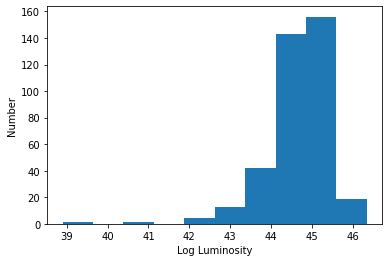

In [37]:
plt.hist(np.log10(ex_L_array[ex_L_array>0]))

plt.xlabel('Log Luminosity')
plt.ylabel('Number')

plt.show()

In [ ]:
# TODO 
# make nice histograms for R,Y,B for z<6 and z<1 
# investigate zeros in lamFlam? 